Code grab: [bakenbaeck](https://tech.bakkenbaeck.com/post/turn-your-selfie-into-a-lego-brick-model), model from [[preparation.ipynb]], and provided directly from git repo at this [link](https://drive.google.com/file/d/1THX-x6TR8Qg7zFfaFXU3cFd9PCZp22IY/view?usp=sharing)

Tried using raw2obj from [Aaron Jackson](https://github.com/AaronJackson/vrn/blob/master/raw2obj.py) and mcubes library: `pip install --upgrade PyMCubes`, but requires visual studio build tools install

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import tensorflow as tf
from tensorflow.core.framework import graph_pb2
from PIL import Image as pil_image
import numpy as np
import cv2
import dlib
from matplotlib import pyplot as plt
import visvis as vv
import os
import shutil
import mcubes
from sklearn.neighbors import NearestNeighbors
#TODO: add extract_face to a utils file and import it

import matplotlib
matplotlib.rcParams['figure.figsize'] = [40,40]

In [3]:
def extract_face(frame):
    '''returns list of face rects: [rectangle(min_x,min_y, max_x,max_y),...], 
    can be used frame[min_y:max_y, min_x:max_x] to return face bounding box (could use padding)'''
    detector = dlib.get_frontal_face_detector()
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    return detector(gray) #detector(gray, 1)

In [4]:
def crop_to_face(frame, face=0):
    '''crops an already loaded BGR frame to the first detected face, plus some padding, convert to RGB'''
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = extract_face(img)
    face = faces[face]

    pad = int(face.width()*.45)
    img = img[face.top()-pad:face.bottom()+pad, face.left()-pad:face.right()+pad]
    img = cv2.resize(img, (192,192), interpolation=cv2.INTER_AREA )
    img = np.float32(img)
    return img

In [5]:
def load_model(path, sess):
    with open(path, "rb") as f:
        output_graph_def = graph_pb2.GraphDef()
        output_graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(output_graph_def, name="")
    x = sess.graph.get_tensor_by_name('input_1_1:0')
    y = sess.graph.get_tensor_by_name('activation_274_1/Sigmoid:0')
    return x,y

In [19]:
def load_image(f):
    '''loads image, crops to face and resizes, with padding'''
    frame = cv2.imread(f)
    img = crop_to_face(frame)
    return img

In [7]:
def reconstruct3d(model, img, sess):
    x, y = model
    img = np.transpose(img, (2,0,1))
    
    vol = sess.run(y, feed_dict={x: np.array([img])})[0] * 255
    
    img = np.transpose(img, (1,2,0))
    
    return vol

In [8]:
def raw2obj(vol, img, f_out):
    '''takes a volume and an img and writes out an obj file to f_out'''
    vertices, triangles = mcubes.marching_cubes(vol, 10)
    
    vertices = vertices[:, (2,1,0)]
    vertices[:,2] *= .5 #scale z-component correctly

    r = img[:,:,0].flatten()
    g = img[:,:,1].flatten()
    b = img[:,:,2].flatten()

    vcx, vcy = np.meshgrid(np.arange(0,192), np.arange(0,192))
    vcx = vcx.flatten()
    vcy = vcy.flatten()
    vc = np.vstack((vcx, vcy, r,g,b)).transpose()

    neigh = NearestNeighbors(n_neighbors=1)

    neigh.fit(vc[:,:2])

    n = neigh.kneighbors(vertices[:,(0,1)], return_distance=False)
    color = vc[n,2:].reshape((vertices.shape[0],3)).astype(float) / 255

    vc = np.hstack((vertices, color))

    with open(f_out, 'w') as f:
        for v in range(0, vc.shape[0]):
            f.write('v %0.2f %0.2f %0.2f %0.2f %0.2f %0.2f\n' % (vc[v,0],vc[v,1],vc[v,2],vc[v,3],vc[v,4],vc[v,5]))

        for t in range(0, triangles.shape[0]):
            f.write('f {} {} {}\n'.format(*triangles[t,:]+1))

Running

In [20]:
sess = tf.Session()
model = load_model('vrn-tensorflow.pb', sess)

In [21]:
img = load_image('dr_mark.jpg')
vol = reconstruct3d(model, img, sess)

In [12]:
# for i, p in enumerate(vol[80:180:5]):
#     plt.subplot(5, 4, i + 1)
#     plt.imshow(p)
    
# plt.show()

Looks Good!!! Now to run and save

Running on a single image

In [22]:
img = load_image('dr_mark.jpg')
vol = reconstruct3d(model, img, sess)
raw2obj(vol, img, 'dr_mark_test.obj')

In [27]:
img[:,:,0]

array([[209., 209., 209., ..., 179., 179., 179.],
       [197., 196., 194., ..., 179., 179., 179.],
       [188., 192., 192., ..., 179., 179., 179.],
       ...,
       [129., 136., 134., ..., 130., 133., 121.],
       [137., 135., 136., ..., 133., 143., 148.],
       [136., 132., 135., ..., 150., 140., 140.]], dtype=float32)

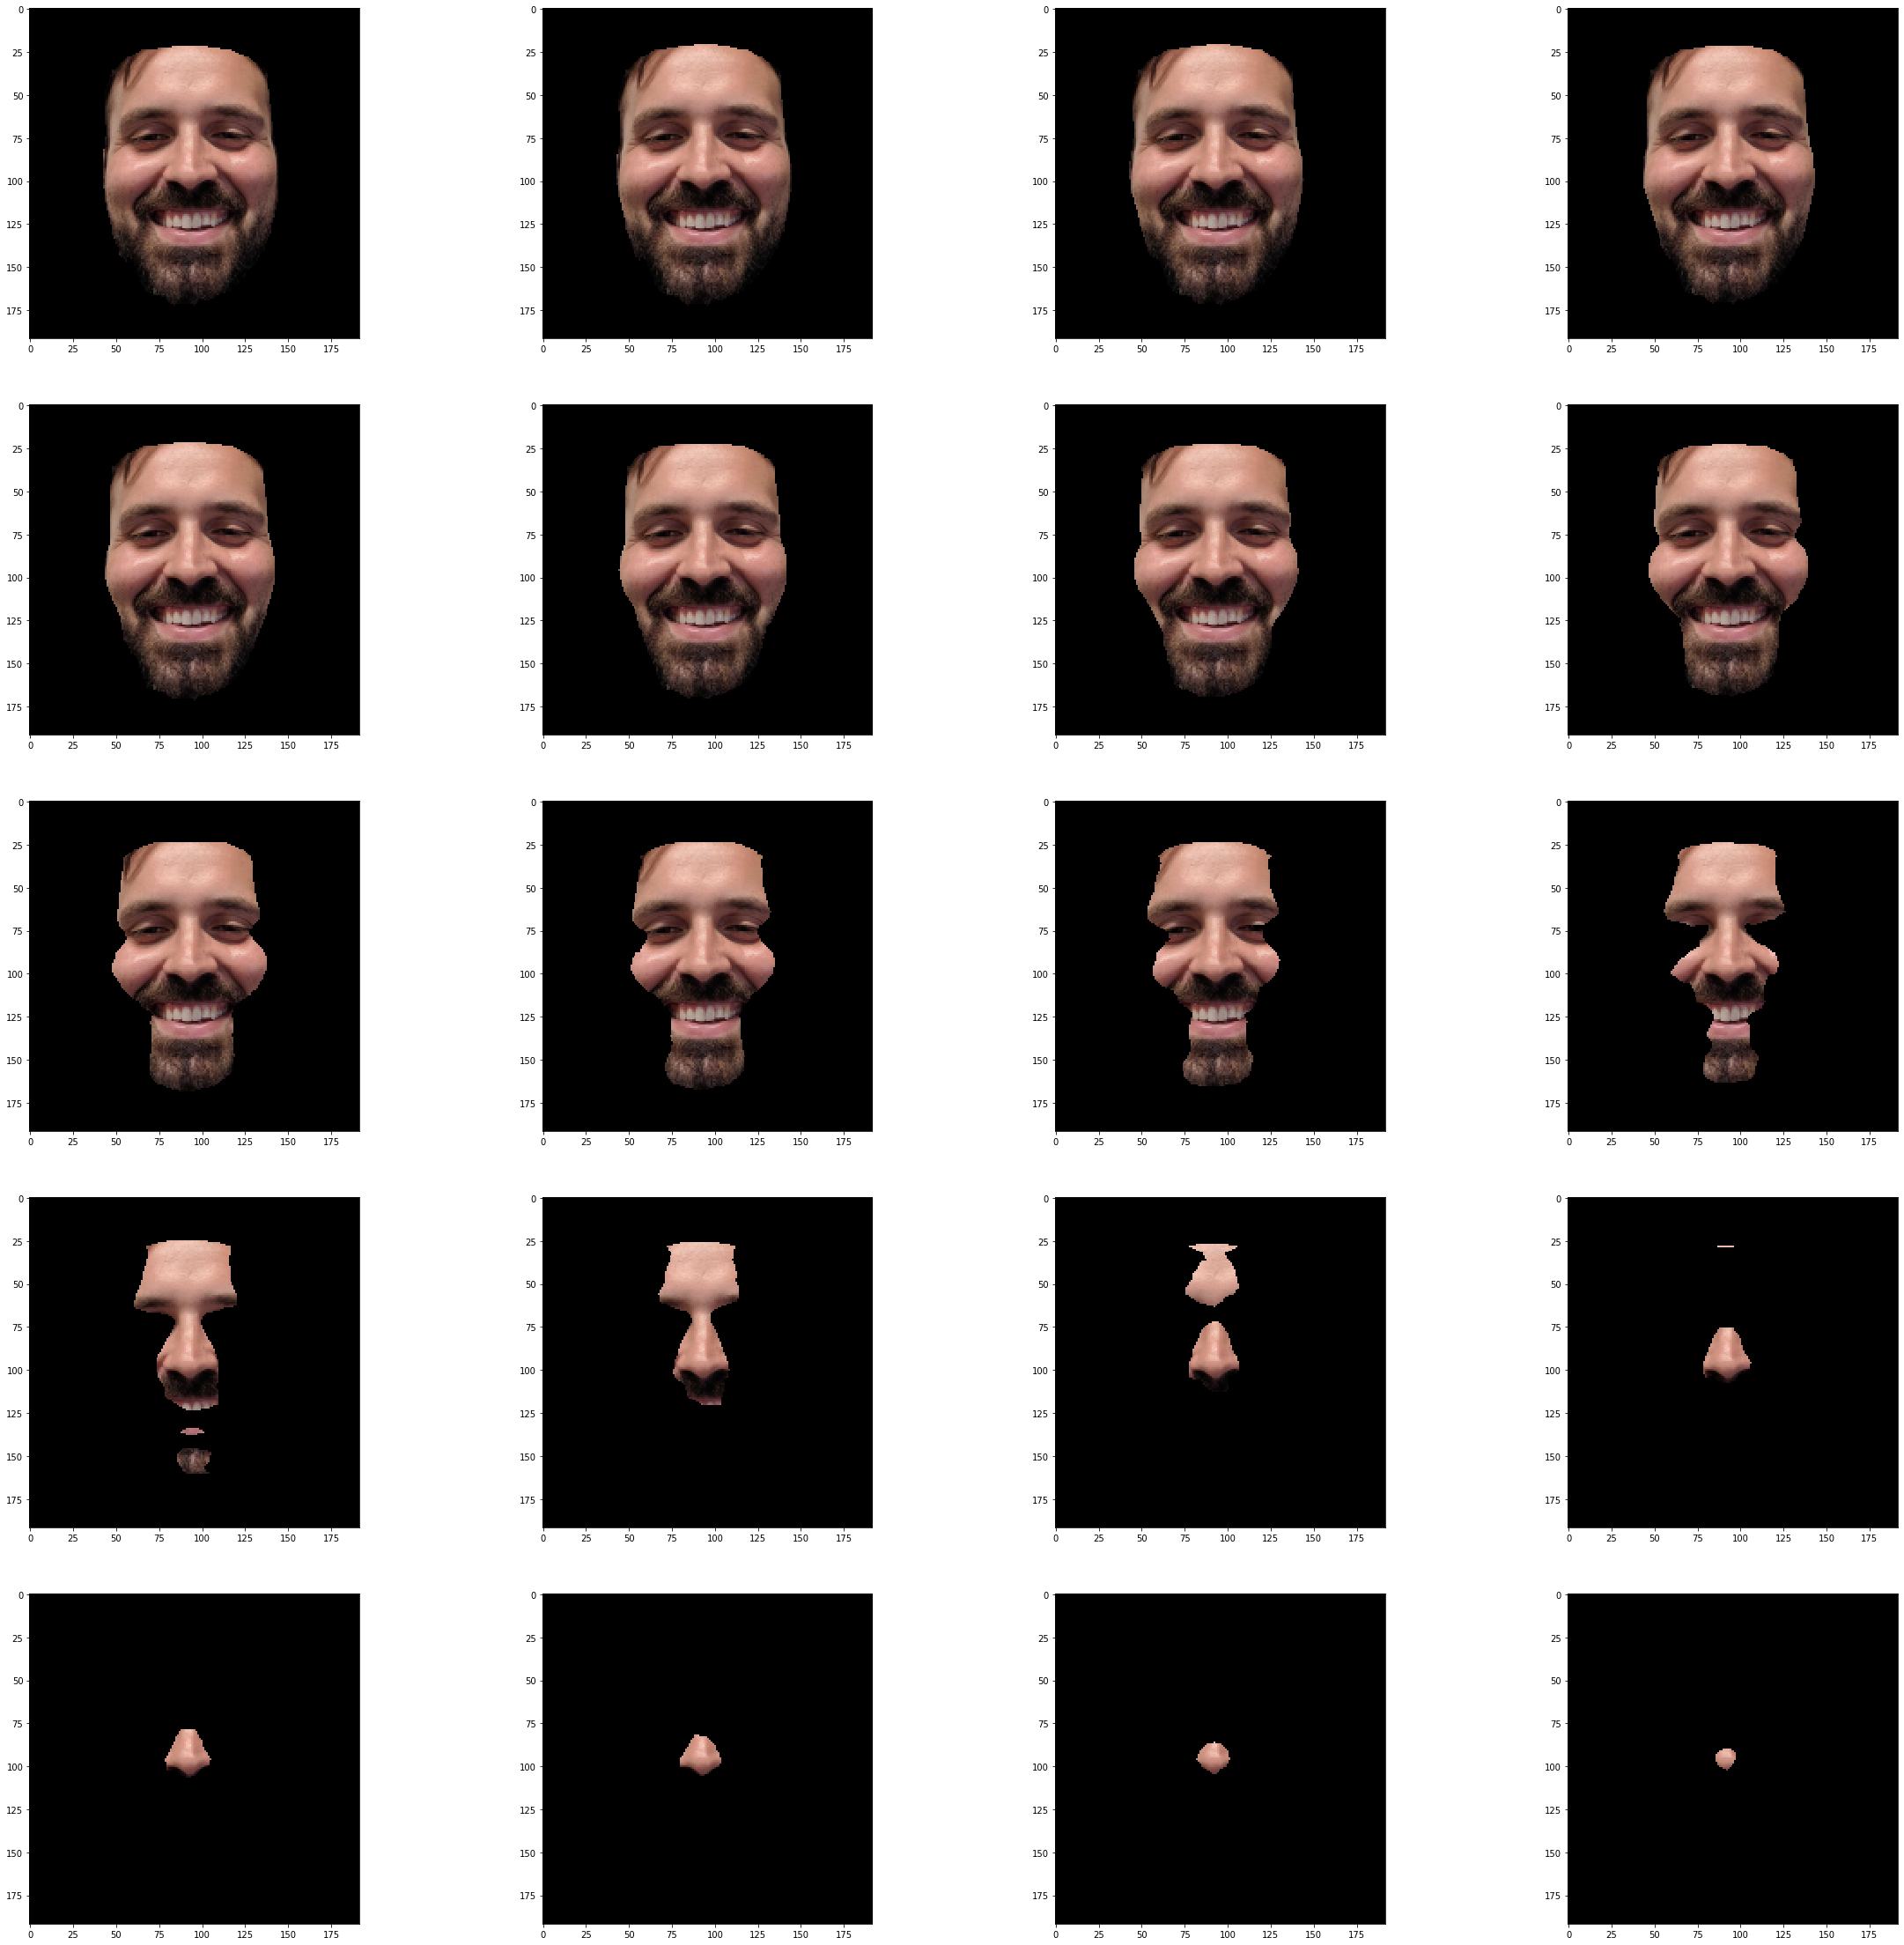

In [29]:
volRGB = np.stack(((vol > 1) * np.uint8(img[:,:,0]),
                   (vol > 1) * np.uint8(img[:,:,1]),
                   (vol > 1) * np.uint8(img[:,:,2])), axis=3)

for i, p in enumerate(volRGB[80:180:5]):
    plt.subplot(5, 4, i + 1)
    plt.imshow(p)
    
plt.show()

In [30]:
vv.clf()

t = vv.imshow(img)
t.interpolate = True

v = vv.volshow(volRGB, renderStyle='iso')

l0 = vv.gca()
l0.light0.ambient = 0.9 # 0.2 is default for light 0
l0.light0.diffuse = 1.0 # 1.0 is default

a = vv.gca()
a.camera.fov = 0 # orthographic

vv.use().Run()

Run through a full video

In [10]:
sess = tf.Session()
model = load_model('vrn-tensorflow.pb', sess)

In [17]:
cap = cv2.VideoCapture('mark_webcam.mp4')

try:
    if not os.path.exists('data'):
        os.makedirs('data')
except OSError:
    print('error creating dir')

try: 
    if not os.path.exists('objs'):
        os.makedirs('objs')
except OSError:
    print('error creating /objs dir')

In [16]:
# shutil.rmtree('data')
# shutil.rmtree('objs')

In [18]:
currFrame = 0

while(True):
    ret, frame = cap.read()
    if (currFrame == 21 or not ret): break
    
    name = f'./data/frame{currFrame}.jpg'
    if currFrame % 10 == 0: print(f'creating {name}, {ret}')
    cv2.imwrite(name, frame)
    
    img = crop_to_face(frame)
    vol = reconstruct3d(model, img, sess)
    raw2obj(vol, img, f'objs\markFace_{currFrame}.obj')
    if currFrame % 10 == 0: print(f'Calculated frame_{currFrame}\'s isosurface.')
    
    currFrame +=1
cap.release()
cv2.destroyAllWindows()

creating ./data/frame0.jpg, True
Calculated frame_0's isosurface.
creating ./data/frame10.jpg, True
Calculated frame_10's isosurface.
creating ./data/frame20.jpg, True
Calculated frame_20's isosurface.
